In [11]:
import numpy as np
from geometricus_deep_learning import utils, embedder
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
from glob import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
pdb_folder = "./data/ecod/"

In [3]:
emb = embedder.GeometricusGraphEmbedder.from_model_meta_file("./models/cath_model/meta.pkl")

In [23]:
domain_info = utils.EcodInfo.from_ecod_class_file("data/ecod.latest.domains.txt").ecod_classification

In [29]:
files = {x.split("/")[-1] for x in glob(pdb_folder+"*")}

In [31]:
mappings = {f"{k}.pdbnum.pdb": f"{v.f_id}" for k, v in domain_info.items() if f"{k}.pdbnum.pdb" in files}
keys, counts = np.unique(list(mappings.values()), return_counts=True)
least_allowed_class_count = 50
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
mappings = {k: v for k, v in mappings.items() if v in keys_to_use}
len(keys_to_use), len(mappings)

(65, 5171)

In [32]:
raw_embedding, pdb_ids, labels, predicted_labels = emb.transform(pdb_folder, mappings)

In [33]:
umap_embedding = embedder.umap.UMAP(n_components=10, n_neighbors=20).fit_transform(raw_embedding)

In [35]:
true_ecod = list()
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            true_ecod.append(1)
        else:
            true_ecod.append(0)

In [43]:
pred_ecod = metrics.pairwise_distances(umap_embedding, metric="braycurtis").flatten()
pred_ecod = pred_ecod.max() - pred_ecod

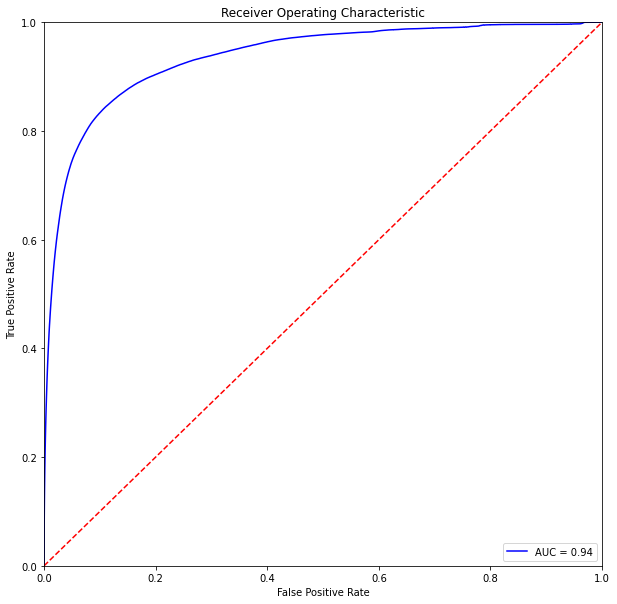

In [44]:
fpr, tpr, threshold = metrics.roc_curve(true_ecod, pred_ecod)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

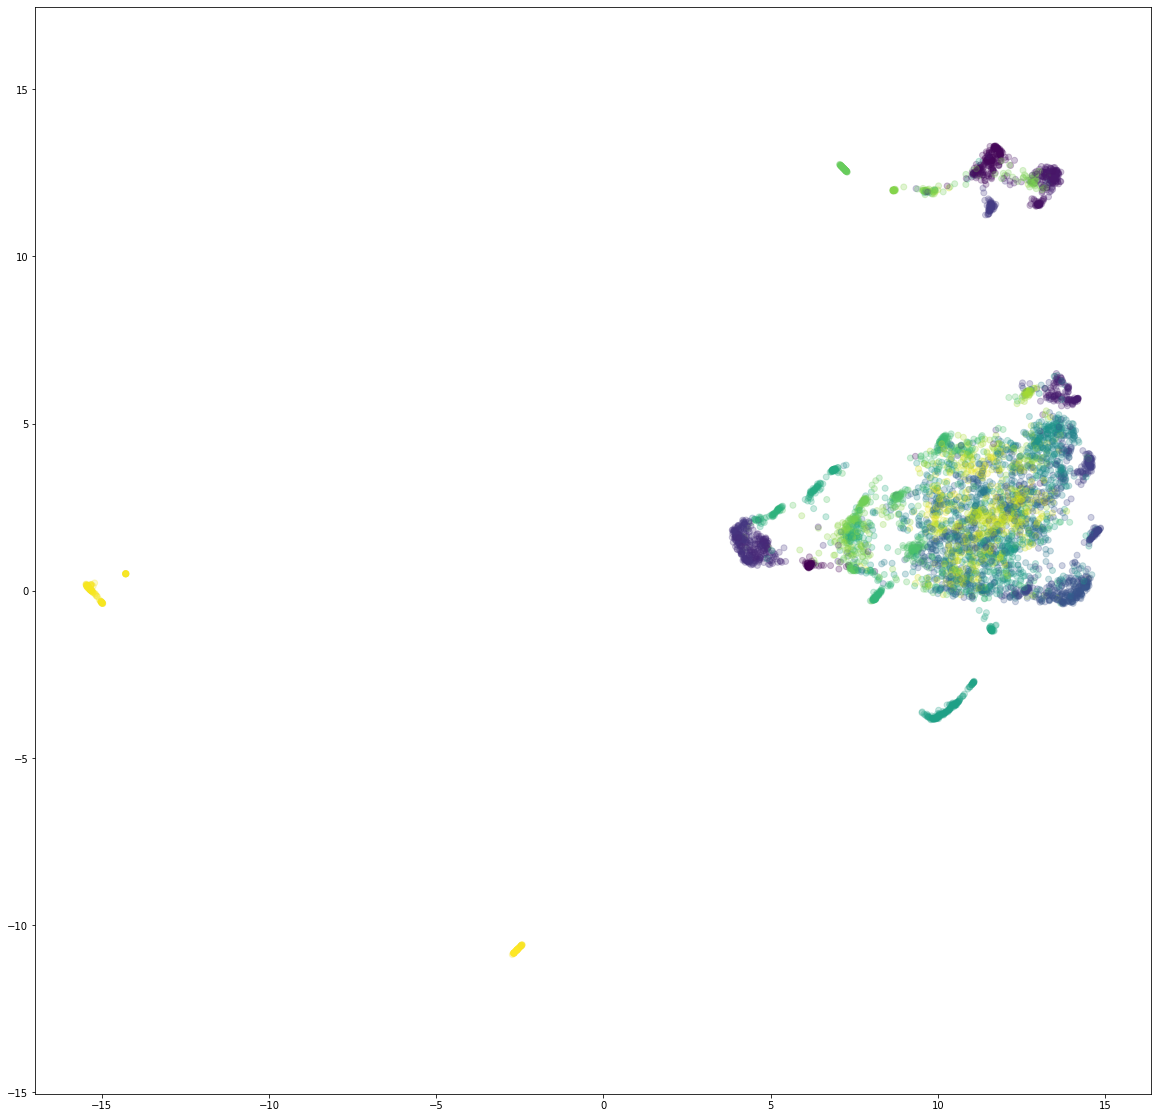

In [42]:
plot_embedding = embedder.umap.UMAP(n_components=2, n_neighbors=200, metric="cosine").fit_transform(raw_embedding)
plt.figure(figsize=(20,20))
plt.scatter(
    plot_embedding[:, 0],
    plot_embedding[:, 1],
    c=labels,
    alpha=.25)
plt.gca().set_aspect('equal', 'datalim')